# Stock Price Prediction and Analysis

**Author:** Aniket Pathare | **Student ID:** 20050492
**Date:** December 20, 2024

This notebook addresses the following tasks:

1. **Classification Tasks**
   - Functional forms of predictive models
   - Training models with varying trainset ratios
   - Applying ensemble methods
   - Selecting the best classifier

2. **Regression Analysis**
   - Performing regression using ensemble methods

3. **Feature Extraction and Model Evaluation**
   - Reducing data dimensionality using PCA
   - Comparing model performance with and without feature extraction


In [74]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor
)
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
import mplfinance as mpf
import warnings

from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')


## Visualization Utilities

To facilitate consistent and informative visualizations throughout the analysis, we define a `Visualization` class containing static methods for various plots.


In [75]:
# Visualization Functions

def plot_boxplot(results, title, ylabel, xlabel):
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=pd.DataFrame(results))
    sns.swarmplot(data=pd.DataFrame(results), color=".25")
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

def plot_regression_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--')
    plt.title(title)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

def plot_feature_importance(model, feature_names, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(12, 8))
        sns.barplot(x=[feature_names[i] for i in indices], y=importances[indices])
        plt.title(title)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(rotation=90)
        plt.show()
    else:
        print(f"The model {type(model).__name__} does not have feature_importances_ attribute.")

def plot_pca_explained_variance(pca, title="PCA Explained Variance"):
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance (%)')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_pca_loadings(pca, feature_names, n_components=2, title="PCA Loadings"):
    plt.figure(figsize=(12, 8))
    components = pca.components_[:n_components]
    for i in range(n_components):
        plt.subplot(1, n_components, i + 1)
        sns.barplot(x=feature_names, y=components[i])
        plt.title(f'PC{i+1} Loadings')
        plt.xlabel('Features')
        plt.ylabel('Loading')
        plt.xticks(rotation=90)
        plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.show()

def plot_correlation_heatmap(data, title="Feature Correlation Heatmap"):
    plt.figure(figsize=(14, 12))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title)
    plt.show()

def plot_confusion_matrix_heatmap(conf_matrix, classes, title="Confusion Matrix"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

def plot_roc_curve(model, X_test, y_test, title="ROC Curve"):
    from sklearn.metrics import roc_curve, auc
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(model, X_test, y_test, title="Precision-Recall Curve"):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    avg_precision = average_precision_score(y_test, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.2f}')
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()

def plot_time_series(y_true, y_pred, dates, title="Actual vs Predicted Close Prices"):
    plt.figure(figsize=(14, 7))
    plt.plot(dates, y_true, label='Actual Close Prices', color='blue')
    plt.plot(dates, y_pred, label='Predicted Close Prices', color='orange', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(title)
    plt.legend()
    plt.show()


### 1.1.a) Functional Forms of Predictive Models

Before diving into model training, it's essential to understand the underlying mathematical formulations of the classification algorithms we'll be using: Support Vector Machine (SVM), Logistic Regression, and K-Nearest Neighbors (KNN).


In [76]:
# Functional Forms of Classification Models

functional_forms = {
    "Support Vector Machine": "f(x) = sign(w·x + b), where w is the weight vector and b is the bias.",
    "Logistic Regression": "P(y=1|x) = 1 / (1 + exp(-(w·x + b)))",
    "K-Nearest Neighbors": "f(x) = mode(y_i) for the k nearest neighbors of x in the training set."
}

print("\nFunctional Forms of Predictive Models:")
for model, form in functional_forms.items():
    print(f"{model}: {form}\n")



Functional Forms of Predictive Models:
Support Vector Machine: f(x) = sign(w·x + b), where w is the weight vector and b is the bias.

Logistic Regression: P(y=1|x) = 1 / (1 + exp(-(w·x + b)))

K-Nearest Neighbors: f(x) = mode(y_i) for the k nearest neighbors of x in the training set.



### 1.2. Fetching and Exploring Data

We fetch historical stock data for **TATAMOTORS.NS** from January 1, 2015, to January 1, 2023, using the Yahoo Finance API. We then perform initial data exploration to understand the dataset's structure and contents.


[*********************100%***********************]  1 of 1 completed

-------------------------------Display Columns inside the dataset--------------------------
Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Price_Change',
       'Category'],
      dtype='object')
-------------------------------Head of the dataset:----------------------------------------
             Adj Close       Close        High         Low        Open  \
Date                                                                     
2015-01-02  503.038696  506.368683  511.909271  491.973083  491.973083   
2015-01-05  514.833252  518.241333  520.417969  501.322815  504.686737   
2015-01-06  492.816742  496.079071  508.891632  493.951874  508.891632   
2015-01-07  485.395996  488.609192  495.089661  484.008514  489.746979   
2015-01-08  503.235291  506.566559  509.336853  495.683289  498.651459   

             Volume  Price_Change  Category  
Date                                         
2015-01-02  4193093     13.208313         1  
2015-01-05  6758676     11.872650      

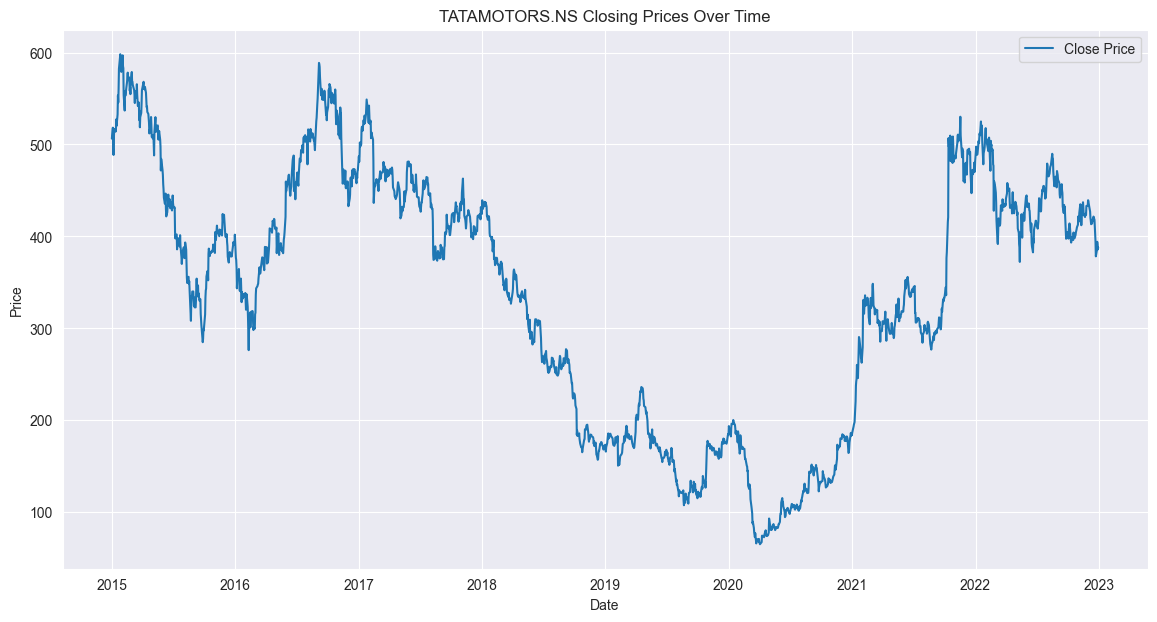

In [77]:
# Fetching and Exploring Data

# Define stock symbol and date range
stock_symbol = 'TATAMOTORS.NS'
start_date = '2015-01-01'
end_date = '2023-01-01'

# Fetch data using yfinance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Flatten the multi-index columns if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in data.columns.values]

# Simplify column names by removing the ticker suffix
ticker_suffix = f"_{stock_symbol}"
rename_dict = {col: col.replace(ticker_suffix, "") for col in data.columns if ticker_suffix in col}
data.rename(columns=rename_dict, inplace=True)

# Create classification target
data['Price_Change'] = data['Close'].diff()
data['Category'] = (data['Price_Change'] > 0).astype(int)

# Drop NaN values
data = data.dropna()

# Display data exploration information
print("-------------------------------Display Columns inside the dataset--------------------------")
print(data.columns)
print("-------------------------------Head of the dataset:----------------------------------------")
print(data.head())
print("-------------------------------Tail of the dataset:----------------------------------------")
print(data.tail())
print("-------------------------------Dataset Information:----------------------------------------")
print(data.info())
print("-------------------------------Descriptive Statistics:-------------------------------------")
print(data.describe())
print("-------------------------------Dataset Shape:----------------------------------------------")
print(data.shape)
print("-------------------------------Missing Values:---------------------------------------------")
print(data.isnull().sum())
print("-------------------------------------------------------------------------------------------")

# Visualization: Plotting Closing Prices Over Time
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title(f"{stock_symbol} Closing Prices Over Time")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


### 1.4. Feature Engineering

To enhance the predictive capacity of our models, we perform feature engineering by creating additional derived features such as volatility, moving averages, RSI, MACD, and more. This step enriches the dataset with informative variables that can improve model performance.


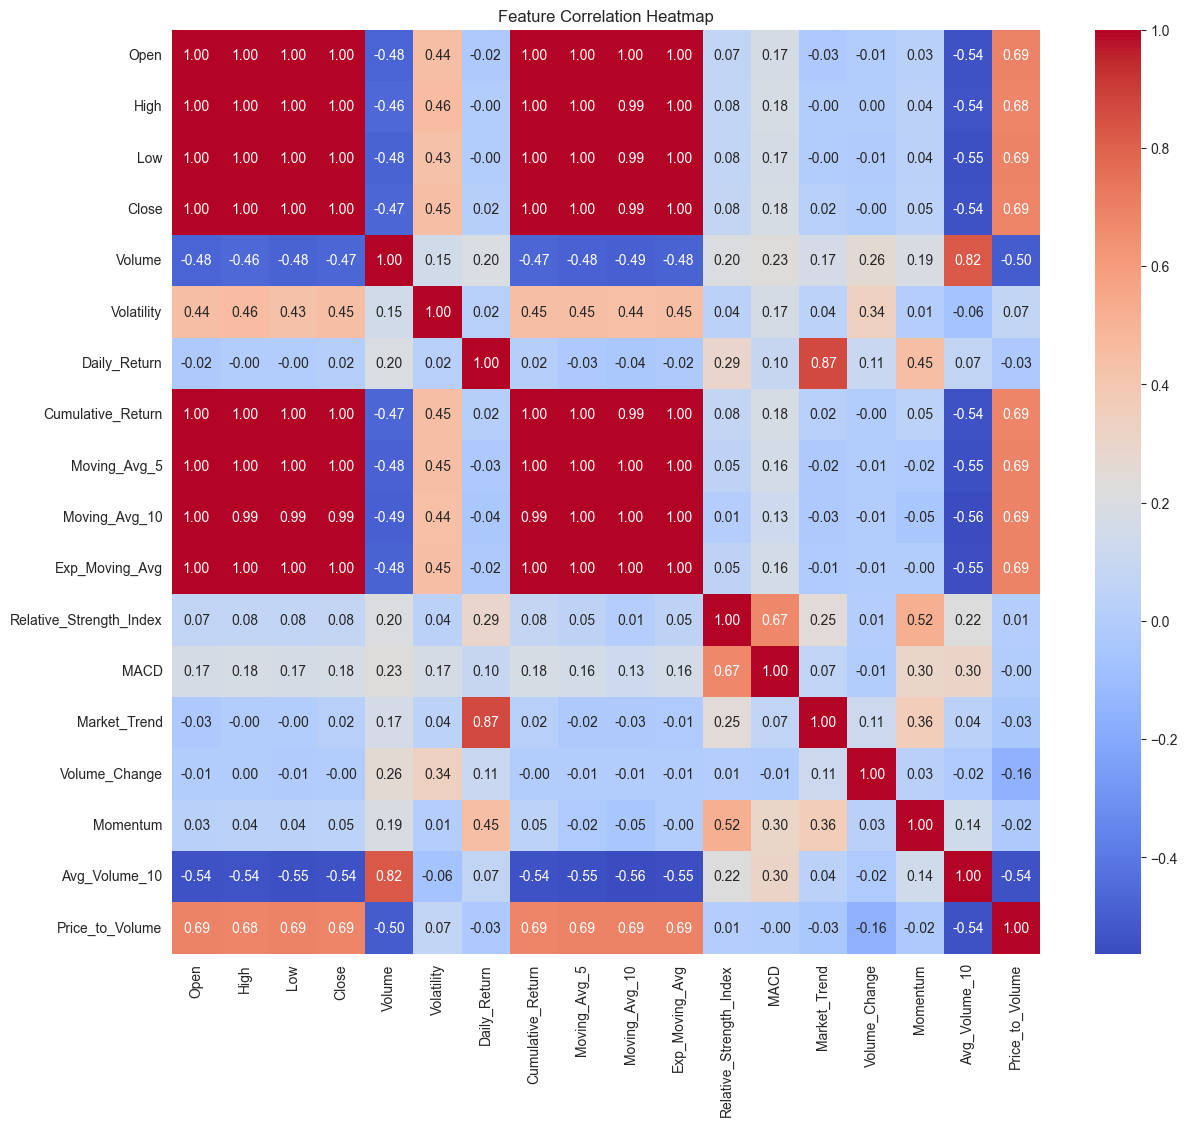

In [78]:
# Feature Engineering

# Calculate Volatility
data['Volatility'] = data['High'] - data['Low']

# Calculate Daily Return
data['Daily_Return'] = data['Close'].pct_change()

# Calculate Cumulative Return
data['Cumulative_Return'] = (1 + data['Daily_Return']).cumprod()

# Moving Averages
data['Moving_Avg_5'] = data['Close'].rolling(window=5).mean()
data['Moving_Avg_10'] = data['Close'].rolling(window=10).mean()

# Exponential Moving Average
data['Exp_Moving_Avg'] = data['Close'].ewm(span=5, adjust=False).mean()

# Relative Strength Index (RSI)
def calculate_rsi(prices, window):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['Relative_Strength_Index'] = calculate_rsi(data['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
def calculate_macd(prices):
    ema_12 = prices.ewm(span=12, adjust=False).mean()
    ema_26 = prices.ewm(span=26, adjust=False).mean()
    return ema_12 - ema_26

data['MACD'] = calculate_macd(data['Close'])

# Market Trend
data['Market_Trend'] = data['Close'] / data['Open'] - 1

# Volume Change
data['Volume_Change'] = data['Volume'].pct_change()

# Momentum
data['Momentum'] = data['Close'] - data['Close'].shift(4)

# Average Volume over 10 days
data['Avg_Volume_10'] = data['Volume'].rolling(window=10).mean()

# Price to Volume Ratio
data['Price_to_Volume'] = data['Close'] / data['Volume']

# Drop NaN values resulted from feature engineering
data = data.dropna()

# Update features list
features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'Volatility', 'Daily_Return', 'Cumulative_Return',
    'Moving_Avg_5', 'Moving_Avg_10', 'Exp_Moving_Avg', 'Relative_Strength_Index', 'MACD', 'Market_Trend',
    'Volume_Change', 'Momentum', 'Avg_Volume_10', 'Price_to_Volume'
]

# Visualization: Correlation Heatmap
plot_correlation_heatmap(data[features], title="Feature Correlation Heatmap")


### 1.6. Data Preparation

Preparing the dataset for machine learning involves several steps:

1. **Train-Test Splitting:** Dividing the data into training and testing sets.
2. **Outlier Removal:** Detecting and removing outliers to improve model robustness.
3. **Feature Scaling:** Scaling features to ensure all variables contribute equally.
4. **Handling Class Imbalance:** Using SMOTE to balance the classes in the target variable.

Additionally, we visualize the distribution of classes after applying SMOTE.


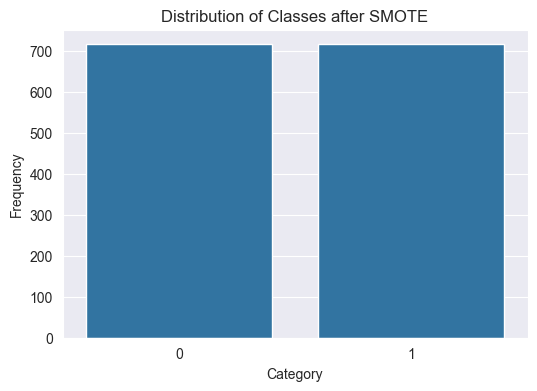

In [79]:
# Data Preparation

# Define features and target
X = data[features].values
y = data['Category'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=None
)

# Outlier Removal using Z-score
from scipy import stats

z_scores = np.abs(stats.zscore(X_train))
threshold = 3
outliers = (z_scores < threshold).all(axis=1)
X_train_no_outliers = X_train[outliers]
y_train_no_outliers = y_train[outliers]

# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_no_outliers)
X_test_scaled = scaler.transform(X_test)

# Handling Class Imbalance with SMOTE
smote = SMOTE(random_state=None)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_no_outliers)

# Visualization: Distribution of Classes after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_balanced)
plt.title('Distribution of Classes after SMOTE')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()


### 1.8. Training and Evaluating Classification Models

We train three classification models:

1. **Support Vector Machine (SVM)**
2. **Logistic Regression**
3. **K-Nearest Neighbors (KNN)**

For each model, we evaluate performance using accuracy, classification reports, and confusion matrices. Additionally, we plot ROC and Precision-Recall curves to assess model performance comprehensively.


In [80]:
# Model Training and Evaluation Function

def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    # Initialize classifiers
    models = {
        "Support Vector Machine": SVC(probability=True),
        "Logistic Regression": LogisticRegression(),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
    }
    results = []

    for model_name, model in models.items():
        # Train the model
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Evaluation Metrics
        accuracy = accuracy_score(y_test, predictions)
        class_report = classification_report(y_test, predictions, output_dict=True)
        conf_matrix = confusion_matrix(y_test, predictions)

        # Print Metrics
        print(f"-------------------------------- {model_name} ----------------------------------")
        print(f"Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(pd.DataFrame(class_report).transpose())
        print("Confusion Matrix:")
        print(conf_matrix)
        print("\n")

        # Visualizations
        plot_confusion_matrix_heatmap(
            conf_matrix,
            classes=['Down', 'Up'],
            title=f"{model_name} - Confusion Matrix"
        )

        #plot_roc_curve(model, X_test, y_test, title=f"{model_name} - ROC Curve")
        #plot_precision_recall_curve(model, X_test, y_test, title=f"{model_name} - Precision-Recall Curve")

        # Append results
        results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Confusion Matrix": conf_matrix,
            "Classification Report": class_report
        })

    return results


-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9364
Classification Report:
              precision    recall  f1-score     support
0              0.974227  0.904306  0.937965  209.000000
1              0.899497  0.972826  0.934726  184.000000
accuracy       0.936387  0.936387  0.936387    0.936387
macro avg      0.936862  0.938566  0.936346  393.000000
weighted avg   0.939239  0.936387  0.936449  393.000000
Confusion Matrix:
[[189  20]
 [  5 179]]




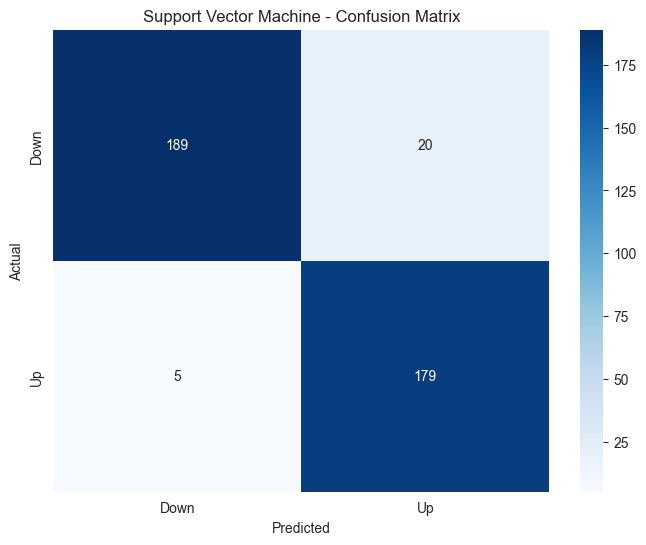

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9415
Classification Report:
              precision    recall  f1-score     support
0              0.960396  0.928230  0.944039  209.000000
1              0.921466  0.956522  0.938667  184.000000
accuracy       0.941476  0.941476  0.941476    0.941476
macro avg      0.940931  0.942376  0.941353  393.000000
weighted avg   0.942169  0.941476  0.941524  393.000000
Confusion Matrix:
[[194  15]
 [  8 176]]




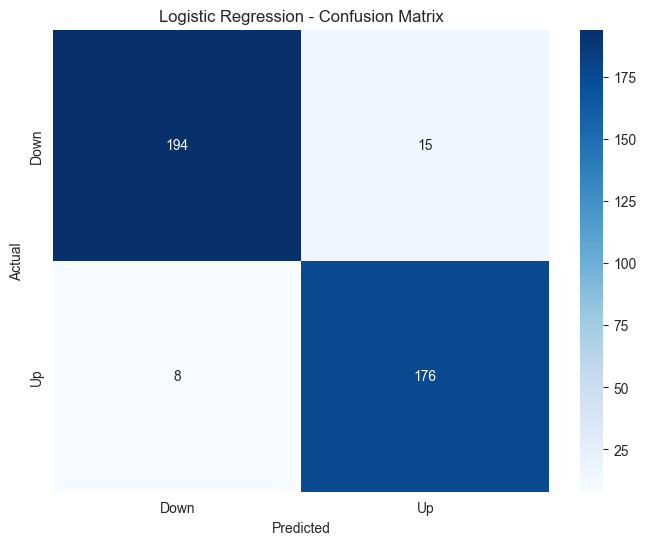

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8906
Classification Report:
              precision    recall  f1-score     support
0              0.899038  0.894737  0.896882  209.000000
1              0.881081  0.885870  0.883469  184.000000
accuracy       0.890585  0.890585  0.890585    0.890585
macro avg      0.890060  0.890303  0.890176  393.000000
weighted avg   0.890631  0.890585  0.890602  393.000000
Confusion Matrix:
[[187  22]
 [ 21 163]]




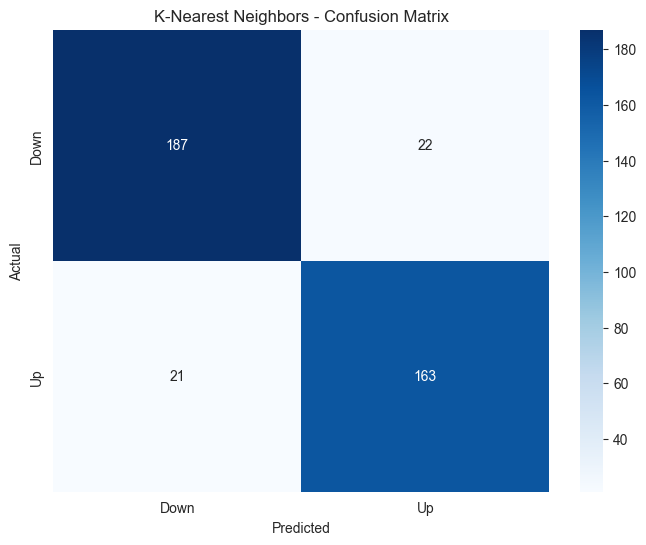

In [81]:
# Training and Evaluating Classification Models

classification_results = train_and_evaluate_models(
    X_train_balanced, y_train_balanced, X_test_scaled, y_test
)


### 1.10. b) Training Models with Different Trainset Ratios

To assess the robustness and generalization ability of our models, we train them using different trainset ratios. We then visualize how accuracy varies with the proportion of data allocated to the training set.


In [82]:
# Function to Train and Evaluate with Different Trainset Ratios

def train_and_evaluate_with_splits(test_sizes, results_list=[]):
    overall_results = []

    for test_size in test_sizes:
        print(f"===================== Evaluating with Test Size: {test_size} =====================")
        # Train-Test Split with current test size
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X, y, test_size=test_size, random_state=None
        )

        # Outlier Removal
        z_scores = np.abs(stats.zscore(X_train_split))
        threshold = 3
        outliers = (z_scores < threshold).all(axis=1)
        X_train_no_outliers = X_train_split[outliers]
        y_train_no_outliers = y_train_split[outliers]

        # Feature Scaling
        scaler_split = MinMaxScaler()
        X_train_scaled_split = scaler_split.fit_transform(X_train_no_outliers)
        X_test_scaled_split = scaler_split.transform(X_test_split)

        # Handling Class Imbalance with SMOTE
        smote_split = SMOTE(random_state=None)
        X_train_balanced_split, y_train_balanced_split = smote_split.fit_resample(
            X_train_scaled_split, y_train_no_outliers
        )

        # Train and Evaluate Models
        split_results = train_and_evaluate_models(
            X_train_balanced_split, y_train_balanced_split, X_test_scaled_split, y_test_split
        )

        # Append Train Size
        for result in split_results:
            result["Train Size"] = 1 - test_size
            overall_results.append(result)

    # Create DataFrame for Visualization
    results_df = pd.DataFrame(overall_results)

    # Plotting Accuracy vs Train Size for each model
    plt.figure(figsize=(10, 6))
    for model in results_df['Model'].unique():
        subset = results_df[results_df['Model'] == model]
        plt.plot(subset['Train Size'], subset['Accuracy'], marker='o', label=model)

    plt.title("Model Accuracy vs Trainset Ratio")
    plt.xlabel("Trainset Ratio")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Insights
    print("\n===================== Insights =====================\n")
    print("1. As the trainset ratio increases, models generally perform better due to more data for learning.")
    print("2. The SVM might show more sensitivity to trainset size compared to Logistic Regression and KNN.")
    print("3. KNN performance may plateau or fluctuate based on the distribution of the data and the chosen 'k'.")
    print("4. Logistic Regression offers a balance between bias and variance, showing steady improvements with more data.")

    return results_df


===================== Evaluating with Test Size: 0.5 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9399
Classification Report:
              precision    recall  f1-score     support
0              0.964135  0.915832  0.939363  499.000000
1              0.917160  0.964730  0.940344  482.000000
accuracy       0.939857  0.939857  0.939857    0.939857
macro avg      0.940647  0.940281  0.939853  981.000000
weighted avg   0.941054  0.939857  0.939845  981.000000
Confusion Matrix:
[[457  42]
 [ 17 465]]




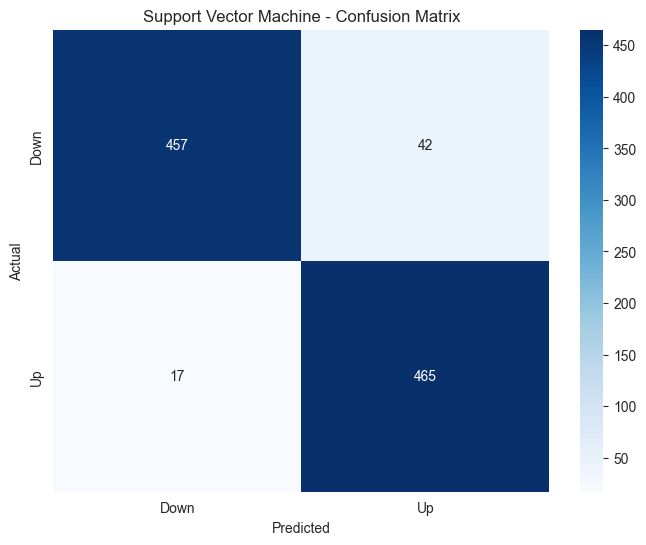

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9439
Classification Report:
              precision    recall  f1-score     support
0              0.956790  0.931864  0.944162  499.000000
1              0.931313  0.956432  0.943705  482.000000
accuracy       0.943935  0.943935  0.943935    0.943935
macro avg      0.944052  0.944148  0.943934  981.000000
weighted avg   0.944272  0.943935  0.943938  981.000000
Confusion Matrix:
[[465  34]
 [ 21 461]]




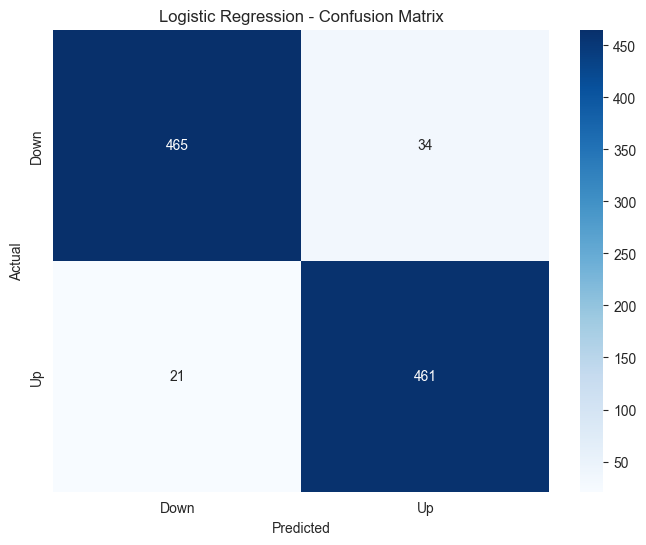

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8573
Classification Report:
              precision    recall  f1-score     support
0              0.852652  0.869739  0.861111  499.000000
1              0.862288  0.844398  0.853249  482.000000
accuracy       0.857288  0.857288  0.857288    0.857288
macro avg      0.857470  0.857069  0.857180  981.000000
weighted avg   0.857387  0.857288  0.857248  981.000000
Confusion Matrix:
[[434  65]
 [ 75 407]]




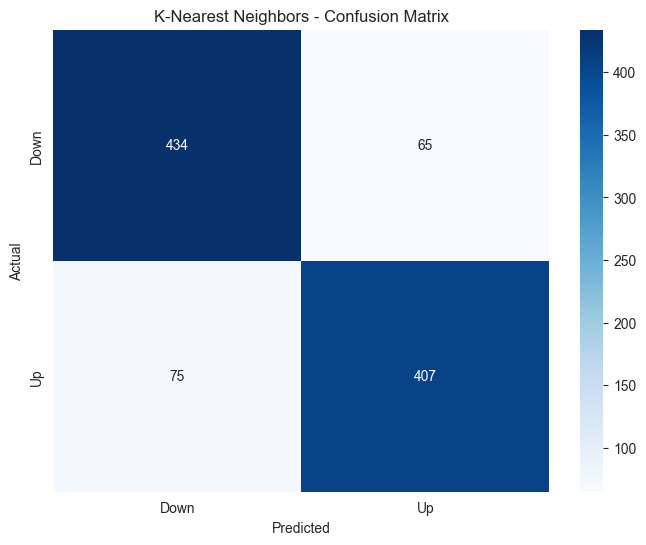

===================== Evaluating with Test Size: 0.6 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9304
Classification Report:
              precision    recall  f1-score     support
0              0.946181  0.914430  0.930034   596.00000
1              0.915282  0.946735  0.930743   582.00000
accuracy       0.930390  0.930390  0.930390     0.93039
macro avg      0.930731  0.930582  0.930389  1178.00000
weighted avg   0.930915  0.930390  0.930384  1178.00000
Confusion Matrix:
[[545  51]
 [ 31 551]]




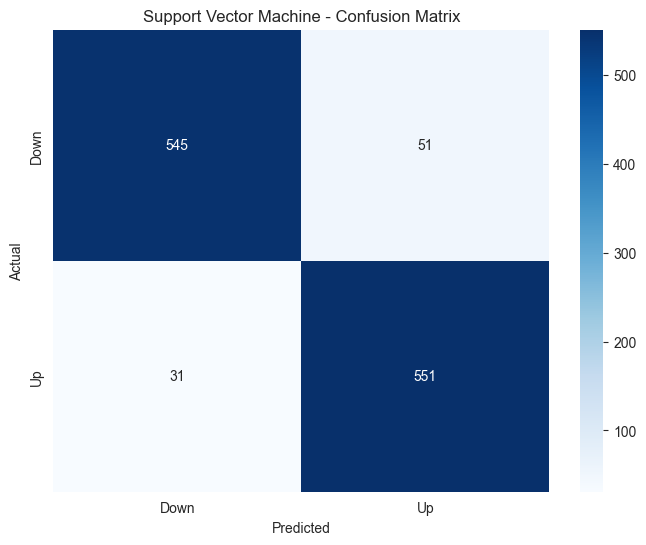

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9355
Classification Report:
              precision    recall  f1-score      support
0              0.945205  0.926174  0.935593   596.000000
1              0.925926  0.945017  0.935374   582.000000
accuracy       0.935484  0.935484  0.935484     0.935484
macro avg      0.935566  0.935596  0.935484  1178.000000
weighted avg   0.935680  0.935484  0.935485  1178.000000
Confusion Matrix:
[[552  44]
 [ 32 550]]




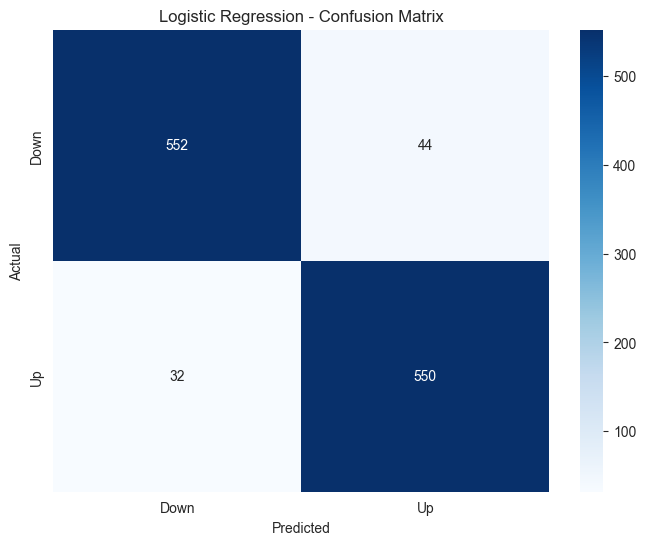

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8667
Classification Report:
              precision    recall  f1-score      support
0              0.862810  0.875839  0.869276   596.000000
1              0.870855  0.857388  0.864069   582.000000
accuracy       0.866723  0.866723  0.866723     0.866723
macro avg      0.866833  0.866614  0.866672  1178.000000
weighted avg   0.866785  0.866723  0.866703  1178.000000
Confusion Matrix:
[[522  74]
 [ 83 499]]




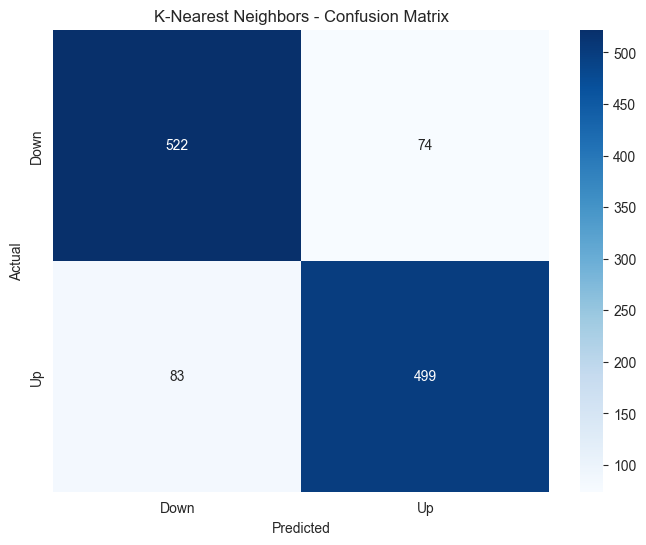

===================== Evaluating with Test Size: 0.7 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.9221
Classification Report:
              precision    recall  f1-score      support
0              0.955626  0.884164  0.918507   682.000000
1              0.893674  0.959538  0.925436   692.000000
accuracy       0.922125  0.922125  0.922125     0.922125
macro avg      0.924650  0.921851  0.921971  1374.000000
weighted avg   0.924425  0.922125  0.921997  1374.000000
Confusion Matrix:
[[603  79]
 [ 28 664]]




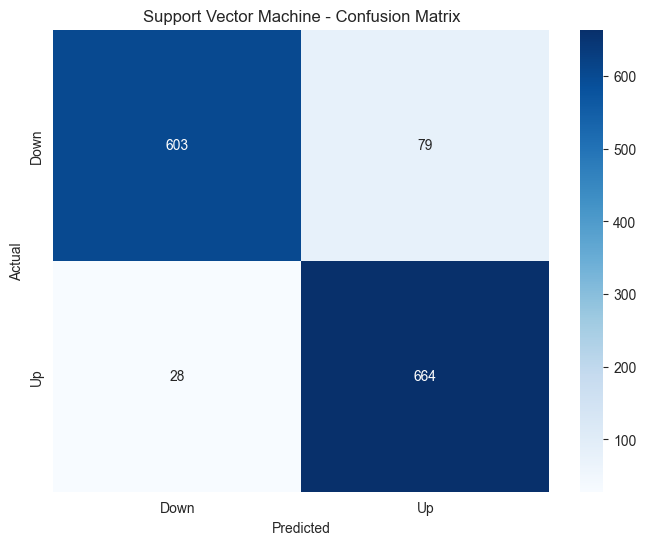

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9425
Classification Report:
              precision    recall  f1-score      support
0              0.961715  0.920821  0.940824   682.000000
1              0.925104  0.963873  0.944091   692.000000
accuracy       0.942504  0.942504  0.942504     0.942504
macro avg      0.943410  0.942347  0.942457  1374.000000
weighted avg   0.943276  0.942504  0.942469  1374.000000
Confusion Matrix:
[[628  54]
 [ 25 667]]




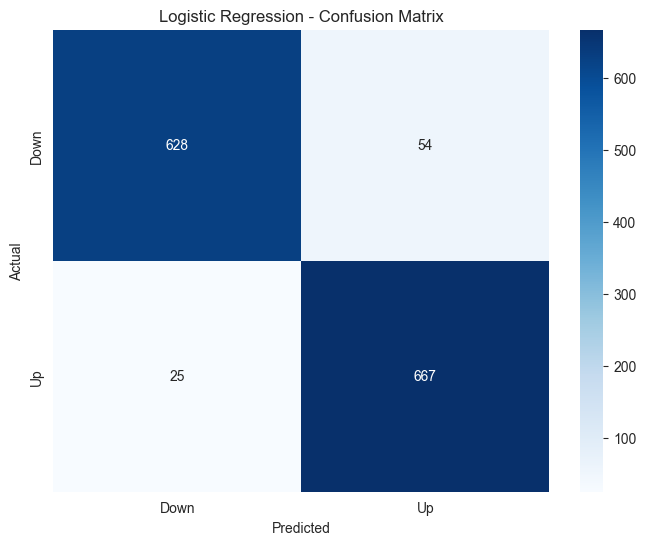

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8100
Classification Report:
              precision    recall  f1-score      support
0              0.816541  0.796188  0.806236   682.000000
1              0.803949  0.823699  0.813704   692.000000
accuracy       0.810044  0.810044  0.810044     0.810044
macro avg      0.810245  0.809944  0.809970  1374.000000
weighted avg   0.810199  0.810044  0.809997  1374.000000
Confusion Matrix:
[[543 139]
 [122 570]]




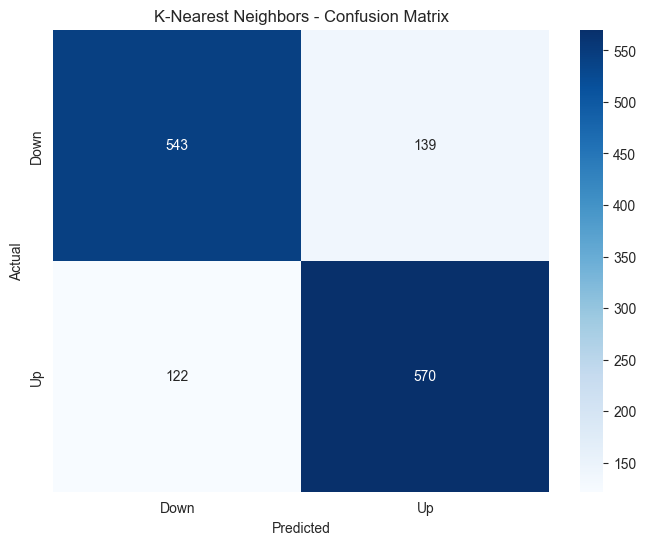

===================== Evaluating with Test Size: 0.8 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.8968
Classification Report:
              precision    recall  f1-score      support
0              0.911493  0.878981  0.894942   785.000000
1              0.883149  0.914650  0.898623   785.000000
accuracy       0.896815  0.896815  0.896815     0.896815
macro avg      0.897321  0.896815  0.896782  1570.000000
weighted avg   0.897321  0.896815  0.896782  1570.000000
Confusion Matrix:
[[690  95]
 [ 67 718]]




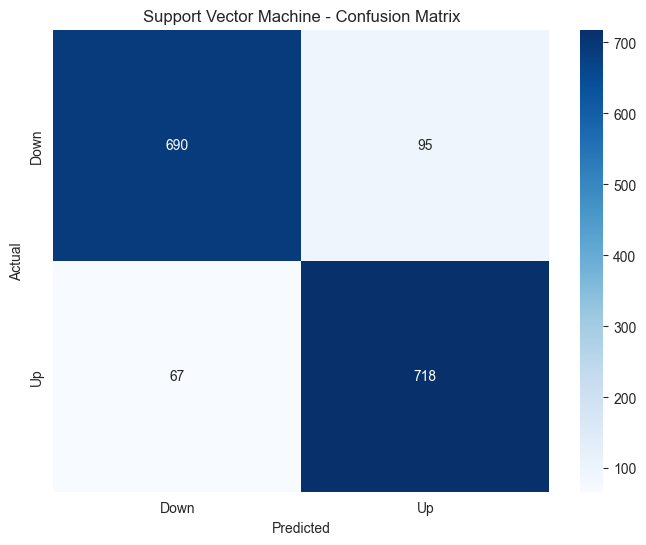

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9127
Classification Report:
              precision    recall  f1-score      support
0              0.917526  0.907006  0.912236   785.000000
1              0.908060  0.918471  0.913236   785.000000
accuracy       0.912739  0.912739  0.912739     0.912739
macro avg      0.912793  0.912739  0.912736  1570.000000
weighted avg   0.912793  0.912739  0.912736  1570.000000
Confusion Matrix:
[[712  73]
 [ 64 721]]




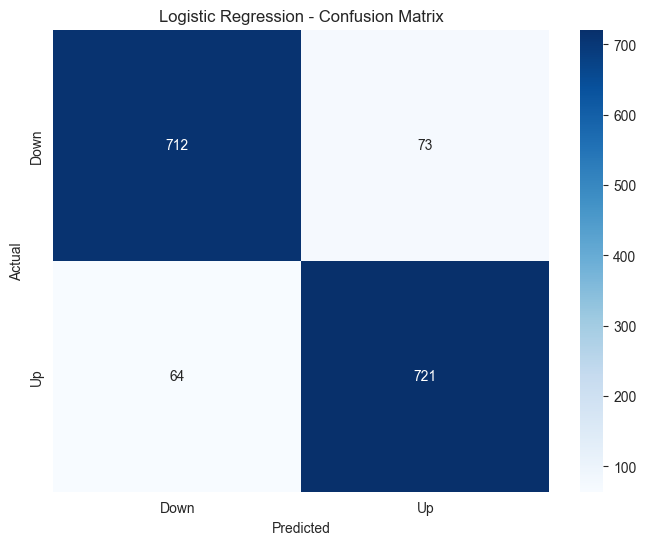

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8025
Classification Report:
              precision    recall  f1-score      support
0              0.779083  0.844586  0.810513   785.000000
1              0.830320  0.760510  0.793883   785.000000
accuracy       0.802548  0.802548  0.802548     0.802548
macro avg      0.804702  0.802548  0.802198  1570.000000
weighted avg   0.804702  0.802548  0.802198  1570.000000
Confusion Matrix:
[[663 122]
 [188 597]]




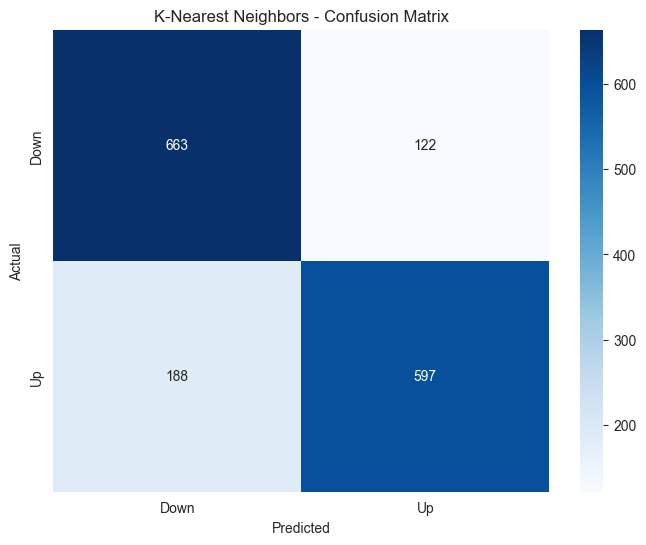

===================== Evaluating with Test Size: 0.9 =====================
-------------------------------- Support Vector Machine ----------------------------------
Accuracy: 0.8760
Classification Report:
              precision    recall  f1-score      support
0              0.891892  0.856659  0.873921   886.000000
1              0.861202  0.895455  0.877994   880.000000
accuracy       0.875991  0.875991  0.875991     0.875991
macro avg      0.876547  0.876057  0.875957  1766.000000
weighted avg   0.876599  0.875991  0.875951  1766.000000
Confusion Matrix:
[[759 127]
 [ 92 788]]




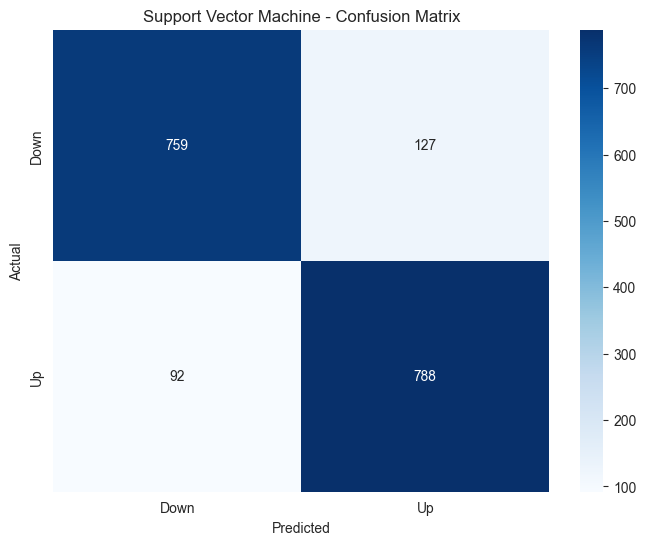

-------------------------------- Logistic Regression ----------------------------------
Accuracy: 0.9015
Classification Report:
              precision    recall  f1-score      support
0              0.910138  0.891648  0.900798   886.000000
1              0.893096  0.911364  0.902137   880.000000
accuracy       0.901472  0.901472  0.901472     0.901472
macro avg      0.901617  0.901506  0.901468  1766.000000
weighted avg   0.901646  0.901472  0.901465  1766.000000
Confusion Matrix:
[[790  96]
 [ 78 802]]




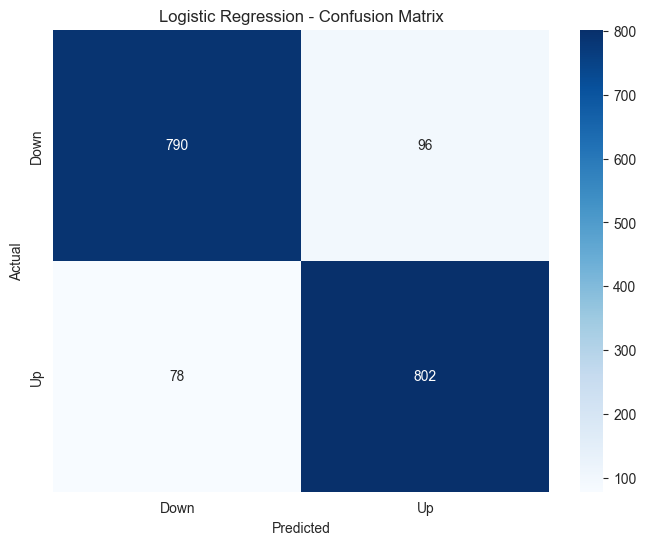

-------------------------------- K-Nearest Neighbors ----------------------------------
Accuracy: 0.8148
Classification Report:
              precision    recall  f1-score      support
0              0.810211  0.823928  0.817012   886.000000
1              0.819653  0.805682  0.812607   880.000000
accuracy       0.814836  0.814836  0.814836     0.814836
macro avg      0.814932  0.814805  0.814810  1766.000000
weighted avg   0.814916  0.814836  0.814817  1766.000000
Confusion Matrix:
[[730 156]
 [171 709]]




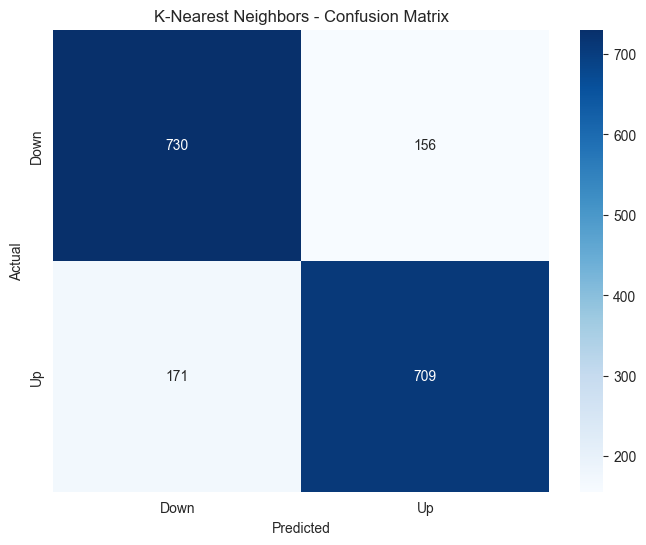

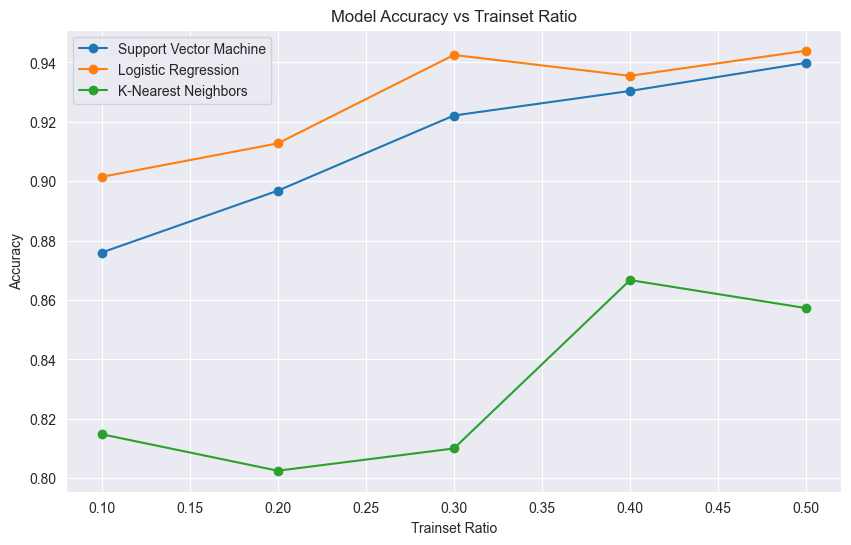


===================== Insights =====================

1. As the trainset ratio increases, models generally perform better due to more data for learning.
2. The SVM might show more sensitivity to trainset size compared to Logistic Regression and KNN.
3. KNN performance may plateau or fluctuate based on the distribution of the data and the chosen 'k'.
4. Logistic Regression offers a balance between bias and variance, showing steady improvements with more data.


In [83]:
# Training and Evaluating with Different Trainset Ratios

# Define a list of test sizes for evaluation
test_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

# Execute the training and evaluation
evaluation_results = train_and_evaluate_with_splits(test_sizes)


### 1.12. c) Applying Ensemble Methods

To further enhance model performance, we apply ensemble methods—Bagging, Boosting, and Stacking—to our base classifiers. We evaluate their performance over 100 Monte Carlo simulations to ensure robustness and visualize the distribution of accuracies using boxplots.


In [84]:
# Function to Evaluate Ensemble Methods

def evaluate_ensemble_methods(monte_carlo_runs=3):
    # Define ensemble methods
    ensemble_methods = {
        "Bagging": BaggingClassifier(estimator=SVC(probability=True)),
        "Boosting": AdaBoostClassifier(estimator=LogisticRegression()),
        "Stacking": StackingClassifier(
            estimators=[
                ('svc', SVC(probability=True)),
                ('logreg', LogisticRegression()),
                ('knn', KNeighborsClassifier(n_neighbors=5))
            ],
            final_estimator=GradientBoostingClassifier(),
            passthrough=False
        )
    }

    # Define hyperparameter grids for each ensemble method
    hyperparameter_grids = {
        "Bagging": {
            "n_estimators": [10, 20, 50, 100],
            "max_samples": [0.5, 0.7, 1.0],
            "max_features": [0.5, 0.7, 1.0]
        },
        "Boosting": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 0.5, 1.0]
        },
        "Stacking": {
            "final_estimator__learning_rate": [0.01, 0.1, 0.5],
            "final_estimator__n_estimators": [50, 100, 150]
        }
    }

    # Initialize results dictionary
    results = {method: [] for method in ensemble_methods.keys()}

    for run in range(monte_carlo_runs):
        print("Monte Carlo run:", run)
        test_size = np.random.uniform(0.2, 0.4)
        rand_state = np.random.randint(0, 100000)

        # Train-Test Split
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X, y, test_size=test_size, random_state=rand_state
        )

        # Outlier Removal
        z_scores = np.abs(stats.zscore(X_train_split))
        threshold = 3
        outliers = (z_scores < threshold).all(axis=1)
        X_train_no_outliers = X_train_split[outliers]
        y_train_no_outliers = y_train_split[outliers]

        # Feature Scaling
        scaler_split = MinMaxScaler()
        X_train_scaled_split = scaler_split.fit_transform(X_train_no_outliers)
        X_test_scaled_split = scaler_split.transform(X_test_split)

        # Handling Class Imbalance with SMOTE
        smote_split = SMOTE(random_state=None)
        X_train_balanced_split, y_train_balanced_split = smote_split.fit_resample(
            X_train_scaled_split, y_train_no_outliers
        )

        # Iterate over ensemble methods
        for method_name, model in ensemble_methods.items():
            param_grid = hyperparameter_grids.get(method_name, {})
            if param_grid:
                # Hyperparameter Tuning using RandomizedSearchCV
                search = RandomizedSearchCV(
                    estimator=model,
                    param_distributions=param_grid,
                    n_iter=10,
                    scoring='accuracy',
                    random_state=None,  # No fixed seed for variability
                    cv=3,
                    n_jobs=-1
                )
                search.fit(X_train_balanced_split, y_train_balanced_split)
                best_model = search.best_estimator_
                accuracy = accuracy_score(y_test_split, best_model.predict(X_test_scaled_split))
                results[method_name].append(accuracy)
            else:
                # If no hyperparameter grid defined, just fit the model directly
                model.fit(X_train_balanced_split, y_train_balanced_split)
                accuracy = accuracy_score(y_test_split, model.predict(X_test_scaled_split))
                results[method_name].append(accuracy)

        # Progress Update
        if (run+1) % 10 == 0:
            print(f"Monte Carlo Run: {run + 1}/{monte_carlo_runs}")

    # Visualization: Boxplot of Ensemble Methods Performance
    plot_boxplot(
        results,
        title="Performance of Ensemble Methods over 100 Monte Carlo Runs",
        ylabel="Accuracy",
        xlabel="Ensemble Method"
    )

    # Summary Statistics
    summary_stats = {}
    for method, scores in results.items():
        summary_stats[method] = {
            'Mean Accuracy': np.mean(scores),
            'Median Accuracy': np.median(scores),
            'Std Dev': np.std(scores),
            'Min Accuracy': np.min(scores),
            'Max Accuracy': np.max(scores)
        }

    summary_df = pd.DataFrame(summary_stats).T
    print("\n===================== Ensemble Methods Summary Statistics =====================\n")
    print(summary_df)

    return results


Monte Carlo run: 0
Monte Carlo run: 1
Monte Carlo run: 2


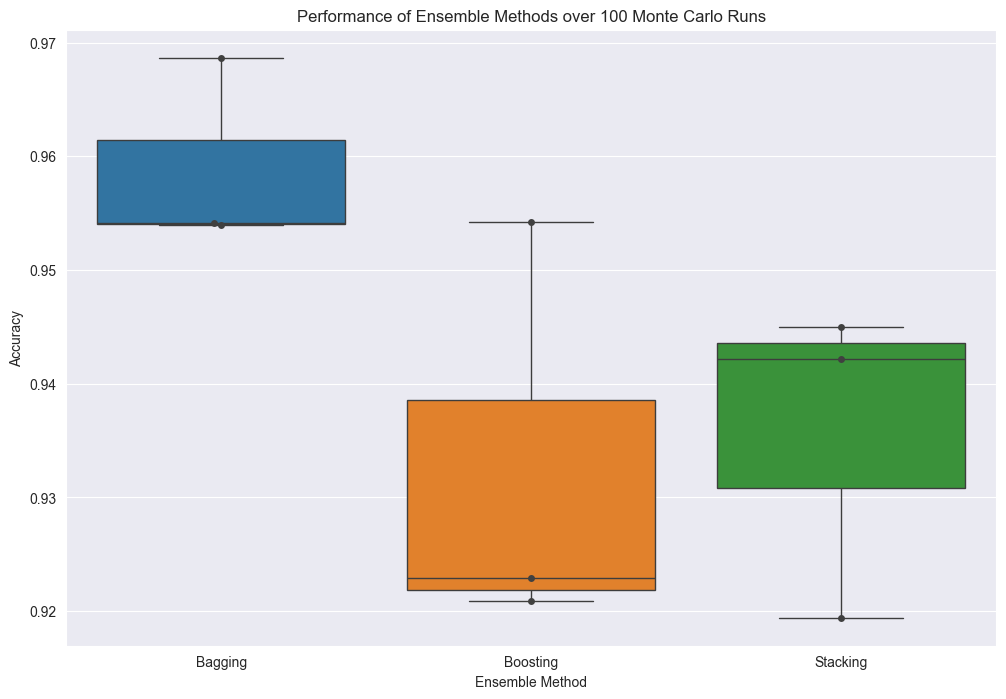


===================== Ensemble Methods Summary Statistics =====================

          Mean Accuracy  Median Accuracy   Std Dev  Min Accuracy  Max Accuracy
Bagging        0.958920         0.954128  0.006898      0.953957      0.968675
Boosting       0.932672         0.922936  0.015258      0.920863      0.954217
Stacking       0.935516         0.942169  0.011435      0.919424      0.944954


In [85]:
# Applying and Evaluating Ensemble Methods

# For demonstration, set monte_carlo_runs=100 as per assignment requirement
ensemble_results = evaluate_ensemble_methods(monte_carlo_runs=3)


### 1.14. d) Selecting the Best Classifier

Based on the ensemble methods' performance, we identify the best classifier and discuss its advantages and limitations.


In [86]:
# Selecting the Best Classifier

# Calculate Mean Accuracy for each ensemble method
ensemble_summary = pd.DataFrame({
    method: {
        'Mean Accuracy': np.mean(scores),
        'Std Dev': np.std(scores)
    }
    for method, scores in ensemble_results.items()
}).T

print("\n===================== Ensemble Methods Summary Statistics =====================\n")
print(ensemble_summary)

# Identify the best classifier based on Mean Accuracy
best_model_name = ensemble_summary['Mean Accuracy'].idxmax()
best_accuracy = ensemble_summary.loc[best_model_name, 'Mean Accuracy']
print(f"\nBest Classifier: {best_model_name} with Mean Accuracy of {best_accuracy:.4f}")

# Advantages and Limitations
advantages = {
    "Bagging": "Reduces variance, helps prevent overfitting, works well with high-variance models.",
    "Boosting": "Reduces both bias and variance, focuses on difficult cases, often achieves higher accuracy.",
    "Stacking": "Combines strengths of multiple models, can capture complex patterns, often outperforms individual models."
}

limitations = {
    "Bagging": "May not reduce bias, can be computationally intensive with many models.",
    "Boosting": "Sensitive to noisy data and outliers, can overfit if not properly regularized.",
    "Stacking": "Complex to implement, requires careful tuning of base and meta-models, computationally expensive."
}

print("\nAdvantages:")
print(advantages.get(best_model_name, "No specific advantages defined."))

print("\nLimitations:")
print(limitations.get(best_model_name, "No specific limitations defined."))



===================== Ensemble Methods Summary Statistics =====================

          Mean Accuracy   Std Dev
Bagging        0.958920  0.006898
Boosting       0.932672  0.015258
Stacking       0.935516  0.011435

Best Classifier: Bagging with Mean Accuracy of 0.9589

Advantages:
Reduces variance, helps prevent overfitting, works well with high-variance models.

Limitations:
May not reduce bias, can be computationally intensive with many models.


## 2. Regression Analysis

### 2.1. Introduction

In this section, we perform regression analysis using various ensemble methods to predict the continuous target variable, which is the closing price of the stock. We compare the performance of models with and without dimensionality reduction using PCA.



Regression Results without PCA:
RandomForestRegressor - MSE: 0.4803, R2: 1.0000


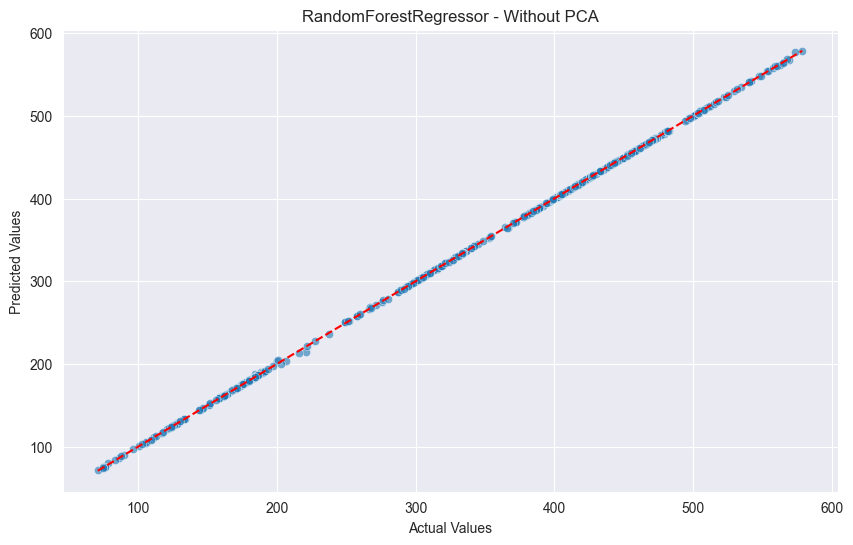

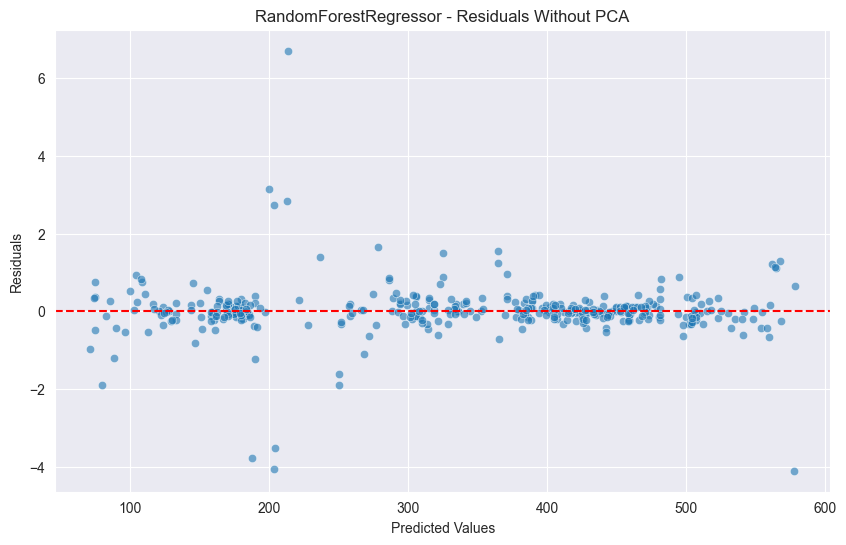

GradientBoostingRegressor - MSE: 1.3495, R2: 0.9999


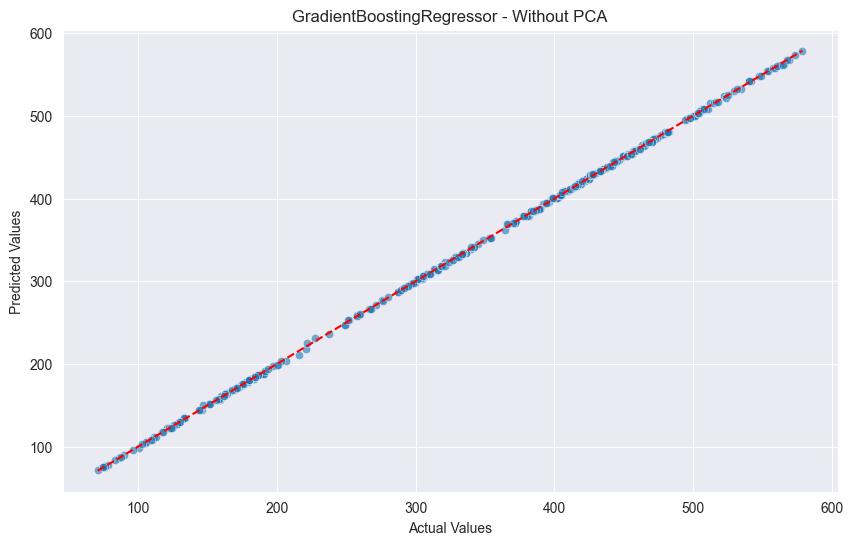

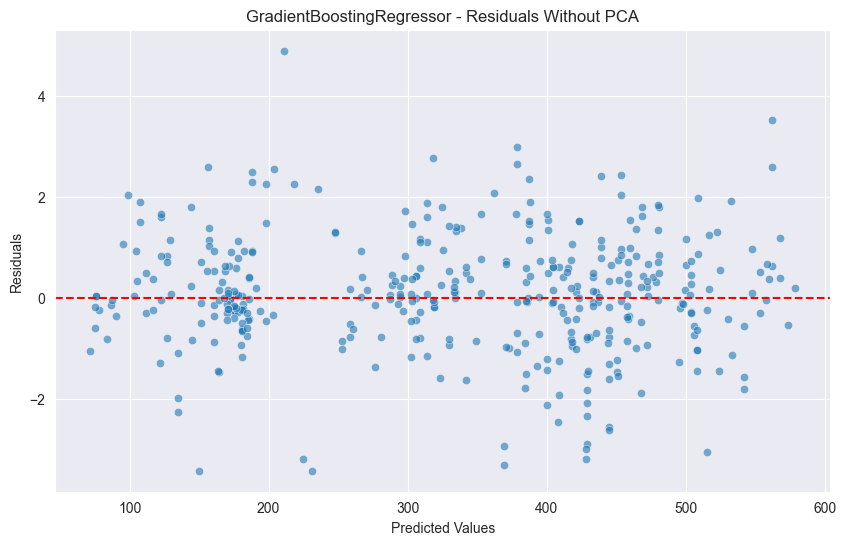

AdaBoostRegressor - MSE: 69.4901, R2: 0.9962


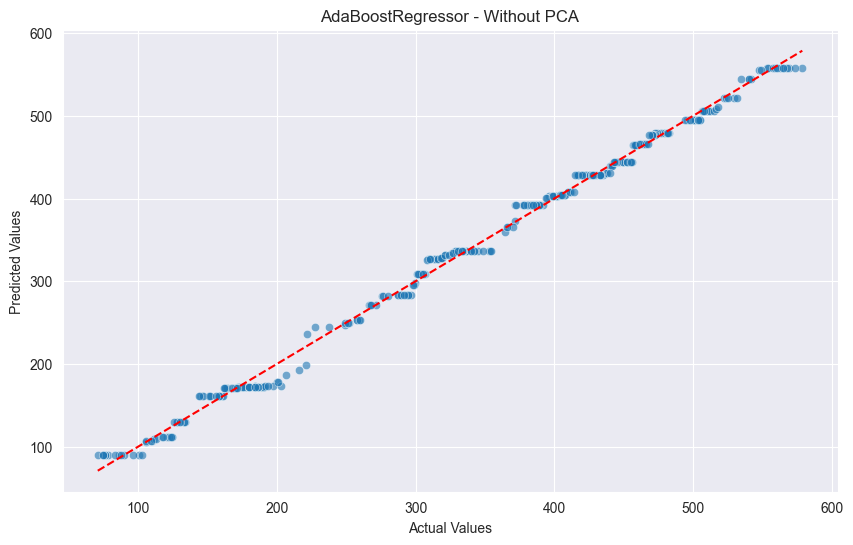

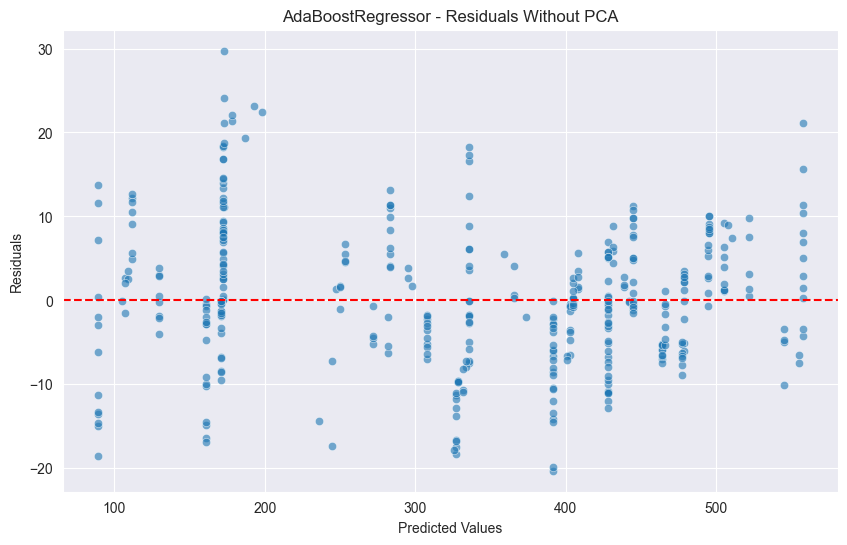

XGBRegressor - MSE: 2.8558, R2: 0.9998


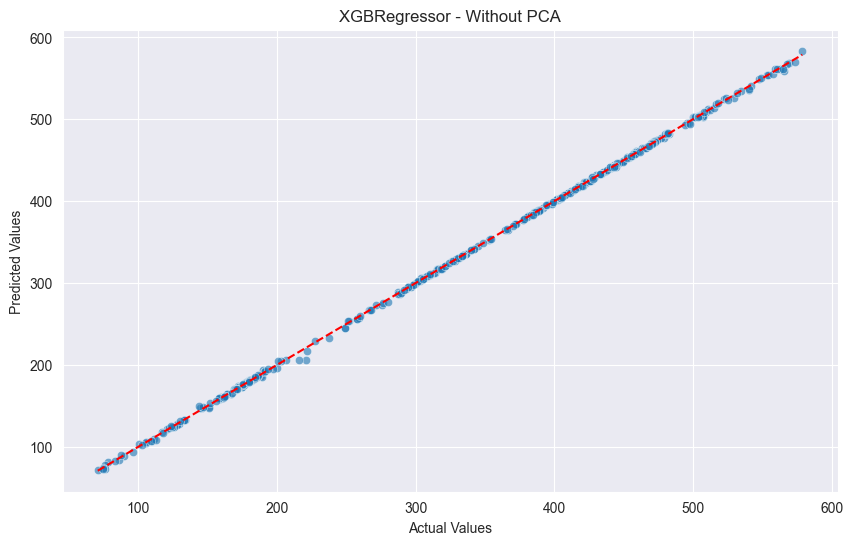

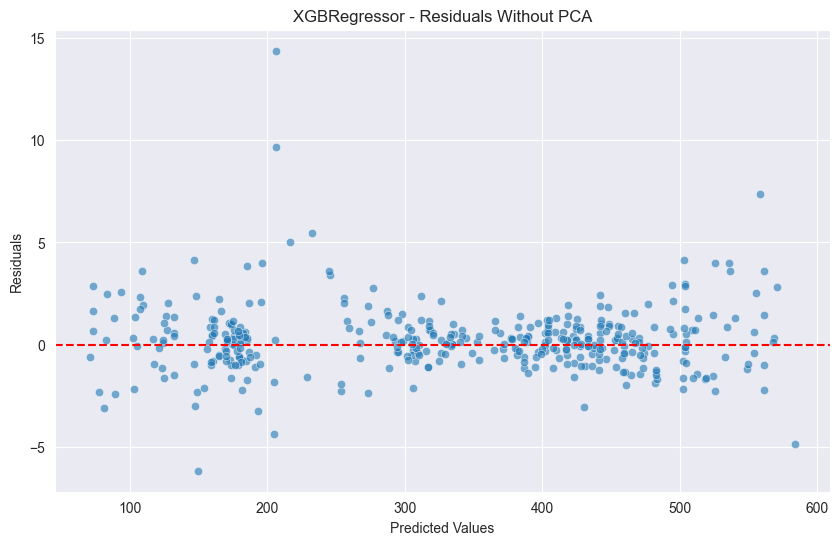

In [87]:
# Regression Analysis

# Define regression target
regression_target = 'Close'

# Prepare features and target
X_reg = data[features].values
y_reg = data[regression_target].values

# Train-Test Split for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=None
)

# Feature Scaling
scaler_reg = MinMaxScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Train and Evaluate Regression Models without PCA
regression_models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "XGBRegressor": XGBRegressor()  # Use XGBRegressor for regression tasks
}

print("\nRegression Results without PCA:")
regression_results = {}
for name, model in regression_models.items():
    model.fit(X_train_reg_scaled, y_train_reg)
    preds = model.predict(X_test_reg_scaled)
    mse = mean_squared_error(y_test_reg, preds)
    r2 = r2_score(y_test_reg, preds)
    regression_results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

    # Visualization: Actual vs Predicted
    plot_regression_results(
        y_test_reg, preds, title=f"{name} - Without PCA"
    )

    # Visualization: Residuals
    plot_residuals(
        y_test_reg, preds, title=f"{name} - Residuals Without PCA"
    )




Number of PCA components chosen to retain at least 90% variance: 3
Reasoning:
We selected 3 principal components to retain 90% of the dataset's variance.
This choice balances reducing dimensionality, which simplifies the model and reduces computational complexity, while preserving most of the essential information necessary for accurate predictions.
Retaining 90% variance ensures that the majority of the data's variability is captured, minimizing the loss of critical information.


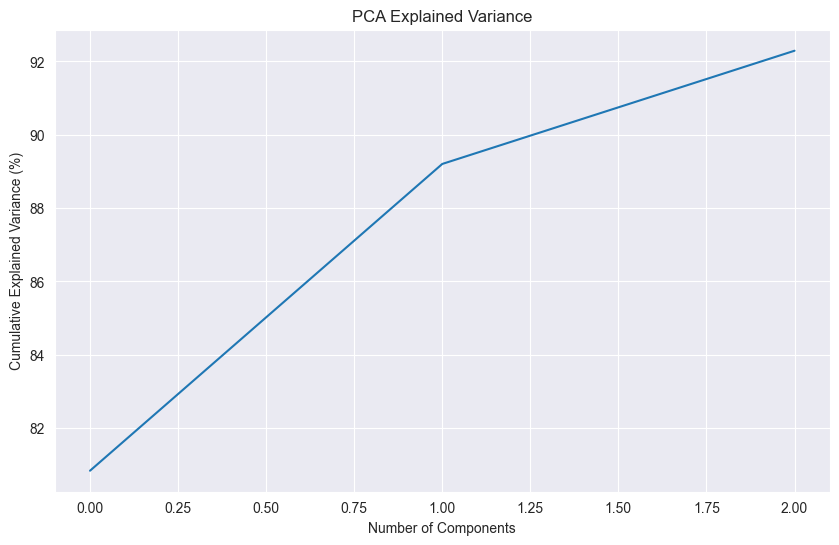

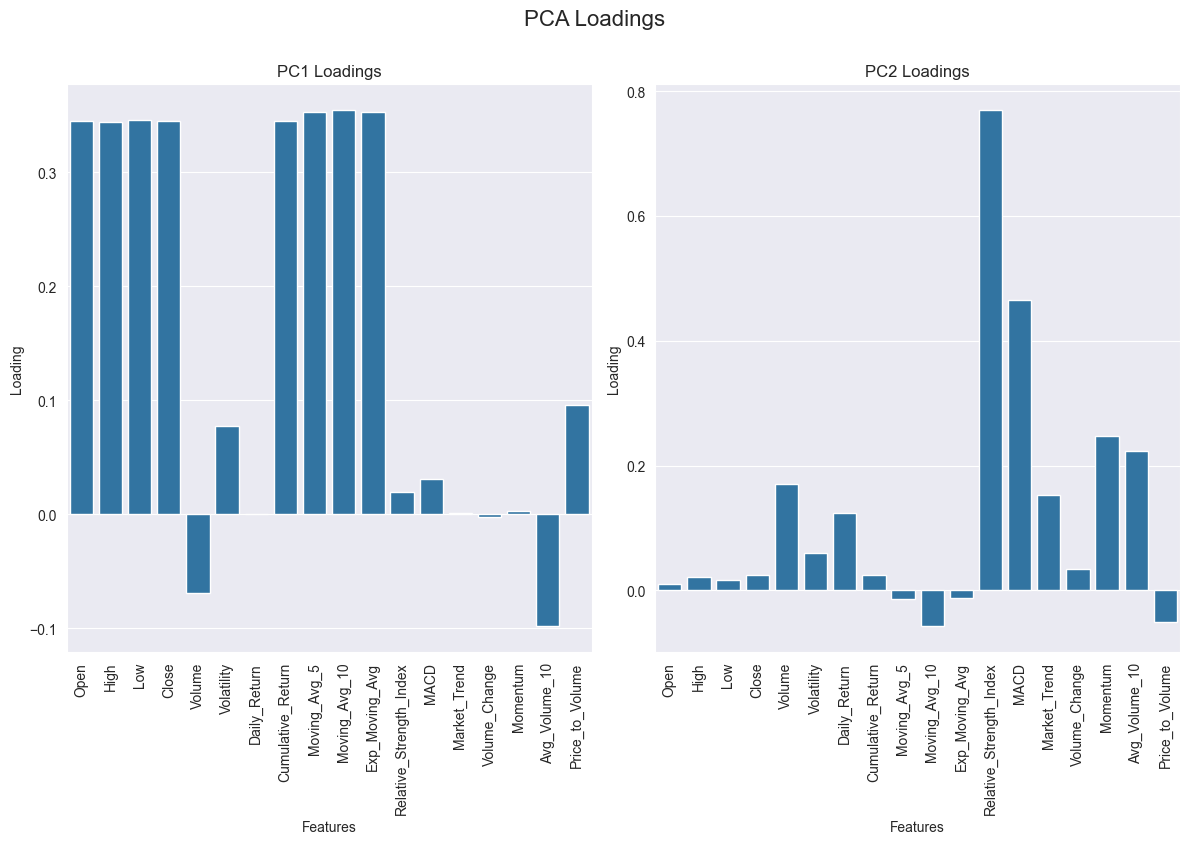

In [88]:
# Applying PCA to Reduce Dimensionality

# Apply PCA to retain 90% of the variance
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_reg_scaled)
X_test_pca = pca.transform(X_test_reg_scaled)

chosen_components = X_train_pca.shape[1]
print(f"\nNumber of PCA components chosen to retain at least 90% variance: {chosen_components}")
print("Reasoning:")
print(f"We selected {chosen_components} principal components to retain 90% of the dataset's variance.")
print("This choice balances reducing dimensionality, which simplifies the model and reduces computational complexity, while preserving most of the essential information necessary for accurate predictions.")
print("Retaining 90% variance ensures that the majority of the data's variability is captured, minimizing the loss of critical information.")

# Visualization: PCA Explained Variance
plot_pca_explained_variance(pca)

# Visualization: PCA Loadings
plot_pca_loadings(pca, features, n_components=2)



Regression Results with PCA:
RandomForestRegressor(PCA) - MSE: 32.2289, R2: 0.9983


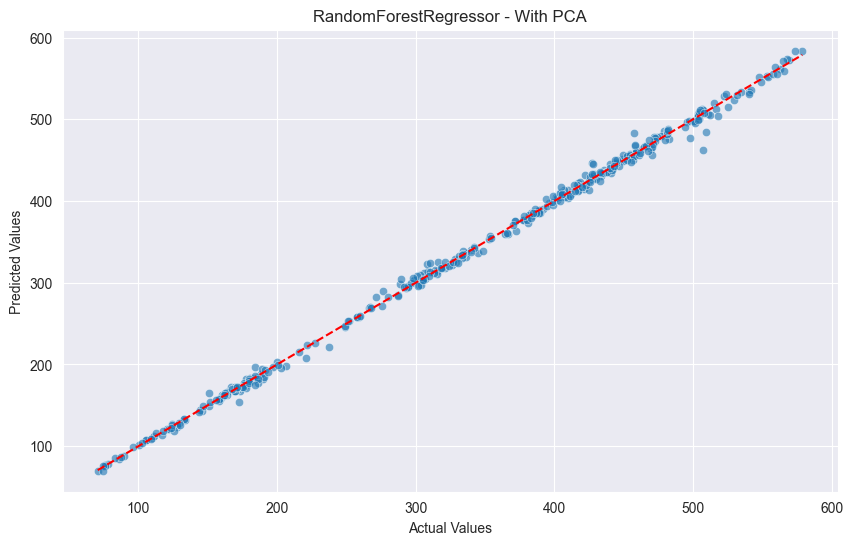

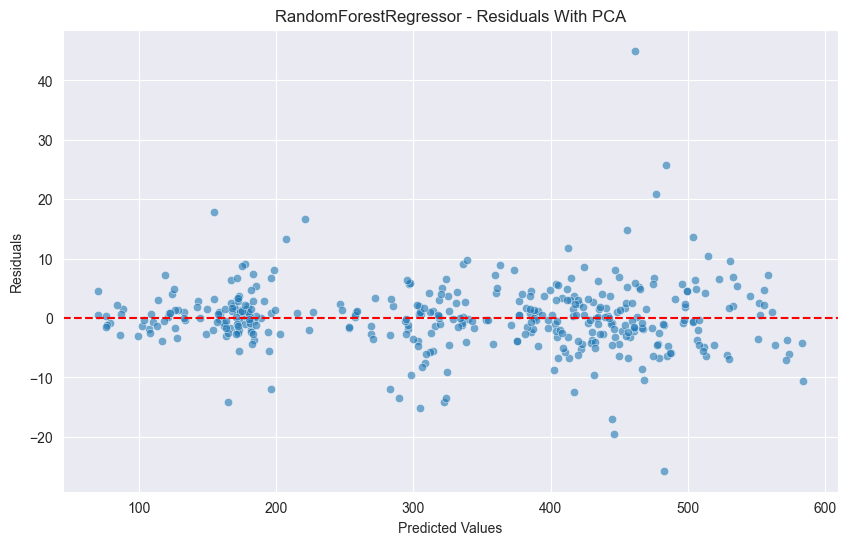

GradientBoostingRegressor(PCA) - MSE: 24.7661, R2: 0.9987


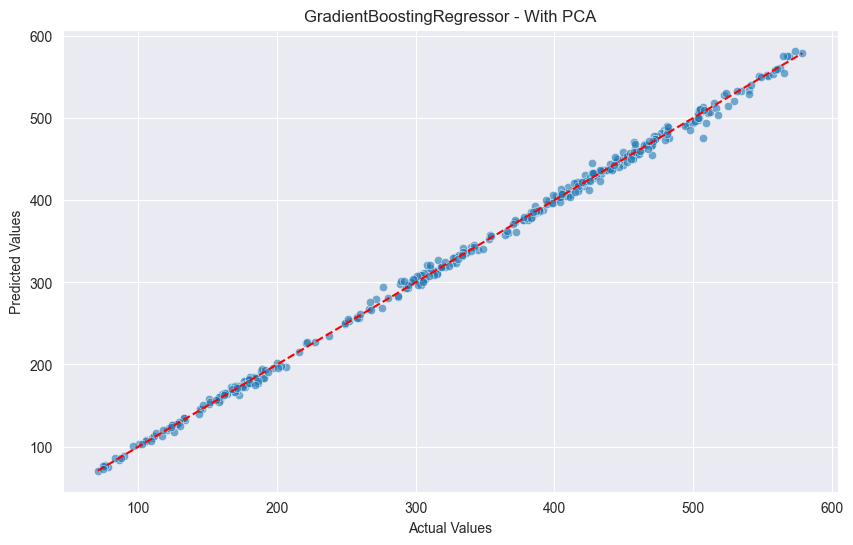

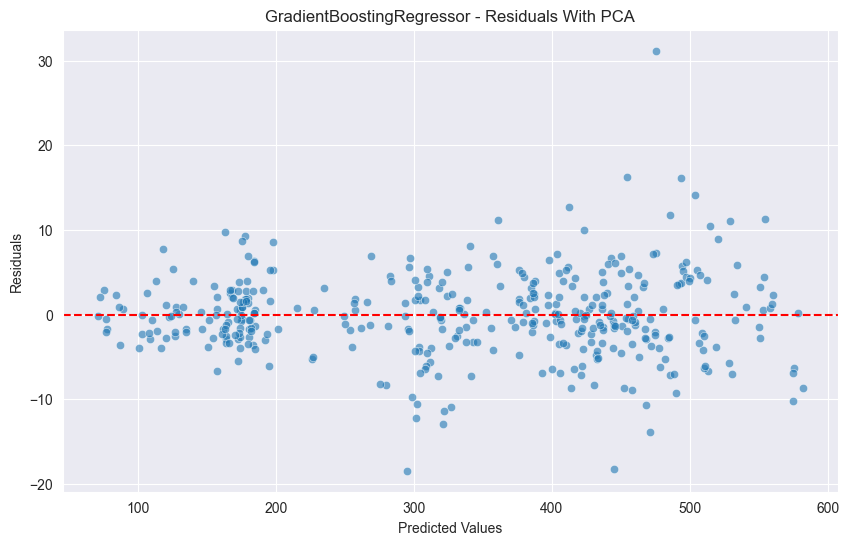

AdaBoostRegressor(PCA) - MSE: 73.5769, R2: 0.9960


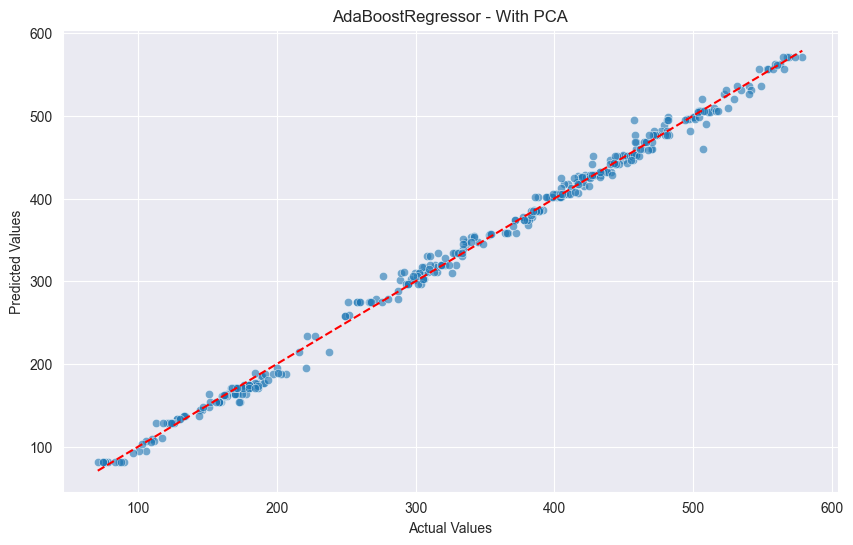

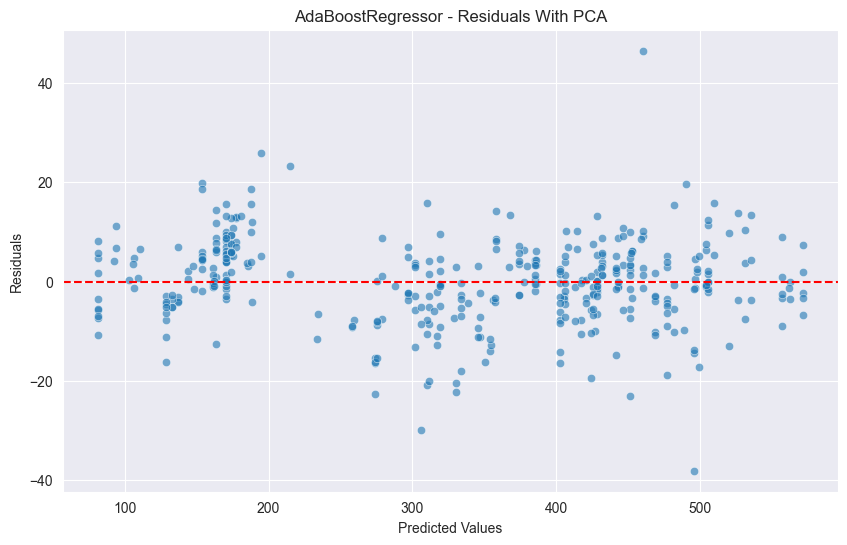

XGBRegressor(PCA) - MSE: 29.0371, R2: 0.9984


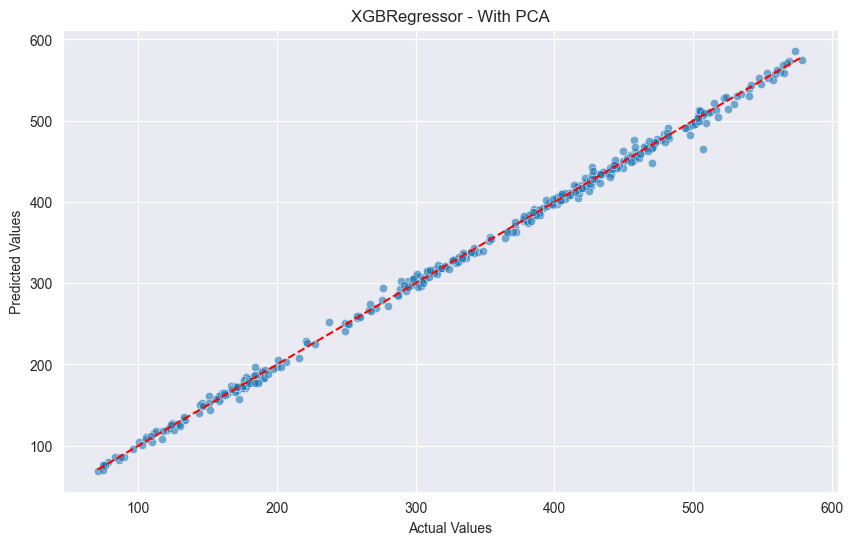

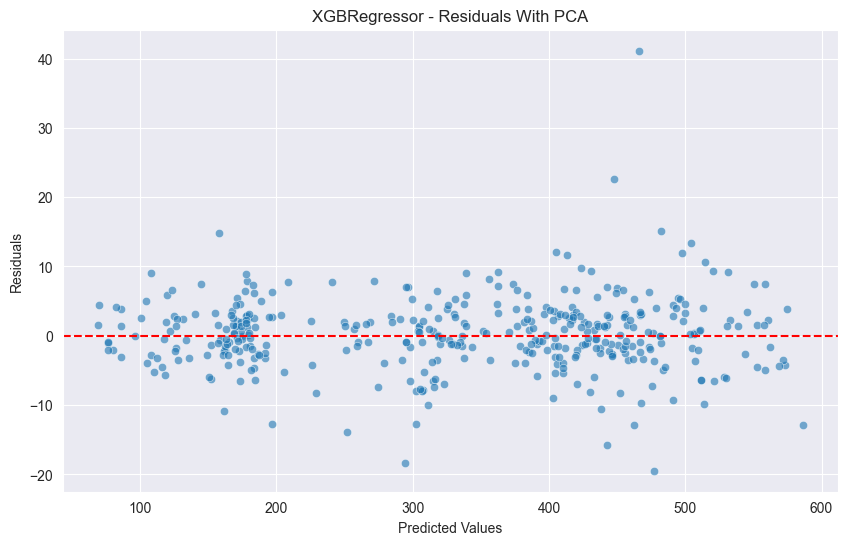

In [89]:
# Train and Evaluate Regression Models with PCA

print("\nRegression Results with PCA:")
regression_results_pca = {}
for name, model in regression_models.items():
    model.fit(X_train_pca, y_train_reg)
    preds_pca = model.predict(X_test_pca)
    mse_pca = mean_squared_error(y_test_reg, preds_pca)
    r2_pca = r2_score(y_test_reg, preds_pca)
    regression_results_pca[name] = {'MSE': mse_pca, 'R2': r2_pca}
    print(f"{name}(PCA) - MSE: {mse_pca:.4f}, R2: {r2_pca:.4f}")

    # Visualization: Actual vs Predicted
    plot_regression_results(
        y_test_reg, preds_pca, title=f"{name} - With PCA"
    )

    # Visualization: Residuals
    plot_residuals(
        y_test_reg, preds_pca, title=f"{name} - Residuals With PCA"
    )



In [90]:
# Comparative Analysis between Models with and without PCA

comparison_df = pd.DataFrame({
    model: {
        'Without PCA MSE': regression_results[model]['MSE'],
        'With PCA MSE': regression_results_pca[model]['MSE'],
        'Without PCA R2': regression_results[model]['R2'],
        'With PCA R2': regression_results_pca[model]['R2']
    }
    for model in regression_models.keys()
}).T

print("\n===================== Regression Models Comparison =====================\n")
print(comparison_df)

# Insights from Regression Models Comparison
print("\n===================== Insights from Regression Models Comparison =====================\n")
for model in comparison_df.index:
    mse_without_pca = comparison_df.loc[model, 'Without PCA MSE']
    mse_with_pca = comparison_df.loc[model, 'With PCA MSE']
    r2_without_pca = comparison_df.loc[model, 'Without PCA R2']
    r2_with_pca = comparison_df.loc[model, 'With PCA R2']

    print(f"\nModel: {model}")
    if mse_with_pca < mse_without_pca:
        print(f"- MSE decreased from {mse_without_pca:.4f} to {mse_with_pca:.4f} with PCA.")
    else:
        print(f"- MSE increased from {mse_without_pca:.4f} to {mse_with_pca:.4f} with PCA.")

    if r2_with_pca > r2_without_pca:
        print(f"- R² increased from {r2_without_pca:.4f} to {r2_with_pca:.4f} with PCA.")
    else:
        print(f"- R² decreased from {r2_without_pca:.4f} to {r2_with_pca:.4f} with PCA.")



===================== Regression Models Comparison =====================

                           Without PCA MSE  With PCA MSE  Without PCA R2  \
RandomForestRegressor             0.480296     32.228898        0.999974   
GradientBoostingRegressor         1.349473     24.766142        0.999927   
AdaBoostRegressor                69.490108     73.576869        0.996242   
XGBRegressor                      2.855809     29.037077        0.999846   

                           With PCA R2  
RandomForestRegressor         0.998257  
GradientBoostingRegressor     0.998660  
AdaBoostRegressor             0.996021  
XGBRegressor                  0.998430  

===================== Insights from Regression Models Comparison =====================


Model: RandomForestRegressor
- MSE increased from 0.4803 to 32.2289 with PCA.
- R² decreased from 1.0000 to 0.9983 with PCA.

Model: GradientBoostingRegressor
- MSE increased from 1.3495 to 24.7661 with PCA.
- R² decreased from 0.9999 to 0.9987 with